# 3D Ising model exploration

### Introduction

##### The Ising model

The Ising model is a simplified model of ferromagnetic materials. The model has N atoms described by their spin defined by a binary variable equal to 1 or -1. Spins are located on a D-dimensional square grid. In this notebook we will consider the 3D version where spins are arranged on a cubic lattice.

Spins interact with their nearest neighbours, and the energy of a configuration
is described by the Hamiltonian

$$
E = -J \sum_{\langle i,j \rangle} s_i s_j,
$$

where:

- J is the strength of ferromagnetic interaction
- the sum runs over all pair (i,j) that are nearest neighbours 

---
##### Boltzmann distribution
At thermal equilibrium, the probability of observing a given spin configuration
\(S\) in the Ising model is given by the Boltzmann distribution

$$
P_B(S) = \frac{1}{Z} \exp\!\left( -\frac{E(S)}{T} \right),
$$

where

- \(E(S)\) is the energy of configuration \(S\),
- \(T\) is the temperature,
- \(Z\) is the **partition function**

$$
Z = \sum_{S} \exp\!\left( -\frac{E(S)}{T} \right),
$$

which ensures that all probabilities sum to 1.

This distribution favours configurations with lower energy (meaning aligned spins),
and suppresses configurations with misaligned neighbours.

---
##### Monte Carlo and Metropolis algorithm
Because the number of possible configurations grows exponentially with system size, direct enumeration becomes impossible.
Instead, we rely on **Markov Chain Monte Carlo** to generate representative
spin configurations according to the Boltzmann distribution:

$$
P(S) \propto e^{-E(S)/T}.
$$

The Metropolis algorithm, is used to propose local spin flips
and accept or reject them based on the energy change:

$$
p_{\text{acc}} = \min\!\left(1, \; e^{-(E_{\text{new}} - E_{\text{old}})/T}\right).
$$

This produces a sequence of configurations that, after equilibration, represent thermal samples
from the 3D Ising model at temperature \(T\).

---
#### Goals of the Project

The purpose of this notebook is to implement and explore the 3D Ising model using the Monte Carlo
methods. We will define the model, simulate its behaviour for different parameters, and analyse how key observables depend on these parameters. We will mainly study how the energy and magnetization will depend on the temperature, number of monte carlo steps or the total number of spins.

Our main research question is:

**How does the magnetization vary with temperature for different system sizes in the 3D Ising model?**

Let's import the packages we will need

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import seaborn as sns
from math import exp

### Defining the functions needed for successful simulation

Let's define the energy calculation function for our 3D model. We will use nearest neighbours for each spin which involve neighbours in the x, y and z direction.

The Hamiltonian of the 3D Ising model with coupling constant $J$ is:

$$
E = -J \sum_{\langle i,j \rangle} s_i s_j,
$$

We sum only over the positive directions o avoid double-counting:

$$
E = -J \sum_{i,j,k}
\left(
s_{i,j,k}\,s_{i+1,j,k}
+ s_{i,j,k}\,s_{i,j+1,k}
+ s_{i,j,k}\,s_{i,j,k+1}
\right).
$$

We implement periodic boundary conditions using modulo indexing:

$$
(i+1) \rightarrow (i+1)\bmod L,\qquad
(j+1) \rightarrow (j+1)\bmod L,\qquad
(k+1) \rightarrow (k+1)\bmod L.
$$


In [32]:
def energy(state, J):
    L = state.shape[0]
    e = 0.0
    for i in range(L):
        for j in range(L):
            for k in range(L):
                s = state[i, j, k]
                e -= J * s * state[(i + 1) % L, j, k]
                e -= J * s * state[i, (j + 1) % L, k]
                e -= J * s * state[i, j, (k + 1) % L]
    return e

Now, let's define the Metropolis acceptance function that will evaluate whether the flip of a spin should be accepted. We compare the
**old** energy $E_{\text{old}}$ with the **new** energy $E_{\text{new}}$ at
temperature $T$.

The Metropolis acceptance probability is

$$
p_{\text{acc}} =
\min\!\left(1,\;\exp\!\left[-\frac{E_{\text{new}} - E_{\text{old}}}{T}\right]\right).
$$

The rules are:

- If $E_{\text{new}} < E_{\text{old}}$ we **always** accept the move.
- If $E_{\text{new}} > E_{\text{old}}$, we accept the move with probability  $\exp\!\left[-(E_{\text{new}} - E_{\text{old}})/T\right]$.


In [33]:
def metropolis(e_old, e_new, T):
    if e_new < e_old:
        return True
    else:
        if np.random.random() < exp((e_old - e_new) / T):
            return True
        return False

Now let's define the **flip and magnetization functions**.

Each spin has either a +1 or -1 value. The **flip function** simply switches the sign of the spin value:

$$
s_{i,j,k} \;\longrightarrow\; -s_{i,j,k},
$$

The **magnetization per spin** is defined as the average of all spins in the
system:

$$
m = \frac{1}{N} \sum_{i,j,k} s_{i,j,k},
$$

In [34]:
def flip(state, i, j, k):
    state[i, j, k] = -state[i, j, k]

def magnetization(state):
    return np.sum(state) / state.size

### Simulation part

##### Example simulation
First let's perform an example simulation to get the idea of how the model works for some standard parameters. Later on we will move to actual testing various combinations.

We first chose the following simulation parameters:

- **side** – linear size of the cubic lattice.  
  For example, side = 10 gives a lattice of (10^3 = 1000) spins.

- **T** – temperature

- **J** – coupling constant.  
  For \(J > 0\) the interaction is ferromagnetic (neighbouring spins prefer to align).

- **nstep** – number of Monte Carlo steps in the simulation.

- **seed** – random seed used to initialise the random number generator,  
  so that the simulation is reproducible.


In [47]:
side = 10
t = 2
J = 1.0  
nstep = 50000
seed = 67  

We begin the simulation by generating a random initial spin configuration for
the 3D lattice. To visualize this 3D configuration, we display the middle 2D slice of the lattice.

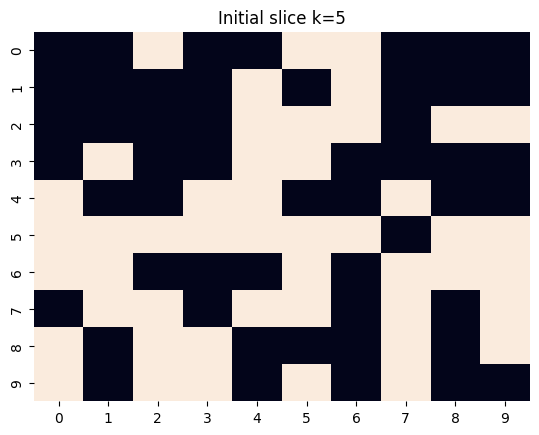

In [48]:
state = 2 * np.random.randint(2, size=(side, side, side)) - 1

mid = side // 2
sns.heatmap(state[:, :, mid], vmin=-1, vmax=1, cbar=False)
plt.title(f"Initial slice k={mid}")
plt.show()

We now perform the Metropolis Monte Carlo simulation. Starting from the initial configuration, we repeatedly propose flipping a randomly chosen spin:

1. Compute the current energy $E_\text{old}$.
2. Flip a single random spin.
3. Compute the new energy $E_\text{new}$.
4. Accept or reject the flip according to the Metropolis rule described before.  
5. Record the energy and magnetization after each step.

In [49]:
e_old = energy(state, J)
e_history = []
m_history = []

rnd.seed(seed)

for istep in range(nstep):
    i = np.random.randint(side)
    j = np.random.randint(side)
    k = np.random.randint(side)

    flip(state, i, j, k)
    e_new = energy(state, J)

    if metropolis(e_old, e_new, t):
        e_old = e_new
    else:
        flip(state, i, j, k)

    e_history.append(e_old)
    m_history.append(magnetization(state))


Let's plot the Energy and magnetization vs step to see the results.

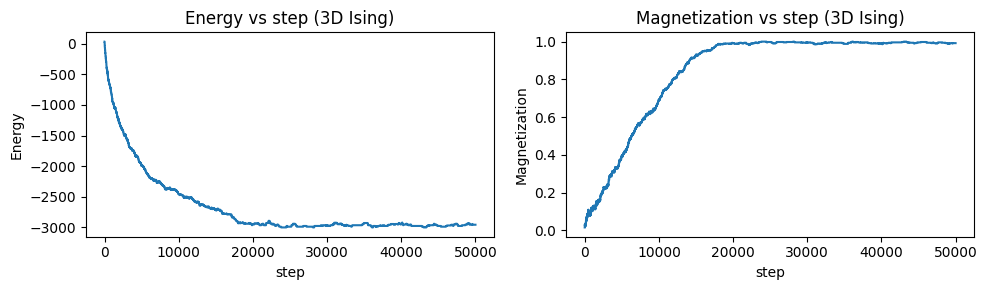

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].plot(e_history)
axes[0].set_xlabel("step")
axes[0].set_ylabel("Energy")
axes[0].set_title("Energy vs step")

axes[1].plot(m_history)
axes[1].set_xlabel("step")
axes[1].set_ylabel("Magnetization")
axes[1].set_title("Magnetization vs step")

plt.tight_layout()
plt.show()

From the two plots we observe that the system equilibrates after roughly 20,000
Monte Carlo steps. The energy curve decreases rapidly at first as the
initially random configuration moves toward lower energy states and then
stabilizes, indicating that equilibrium has been reached. At the same time, the magnetization
increases to 1, showing that the system has entered a ferromagnetic state (vast majority of spins are alligned). After equilibration, both quantities
fluctuate around steady values, consistent with sampling from the Boltzmann distribution.
This behaviour is expected at low temperature, since spin flips that increase the energy are almost always rejected by the Metropolis algorithm.

Let's now check the average energy and magnetization for all of the steps after removing the first 1/3 of them. Those can be considered the equilibrium values.

In [51]:
cut = int(nstep/3)
e_sel = e_history[cut:]
m_sel = m_history[cut:]

avE = np.mean(e_sel)
avM = np.mean(m_sel)

print("Average energy:", avE)
print("Average magnetization:", avM)


Average energy: -2957.959320813584
Average magnetization: 0.9925798884022321
